# Lab 1 Task 2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os
import numpy as np
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from thop import profile
from torchsummary import summary
from tqdm import tqdm

In [2]:
# Check if CUDA is available
print(torch.cuda.is_available())

True


In [3]:
# Calculate mean and std of dataset
def get_mean_std(dataset, ratio=1):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3))
    std = np.std(data.numpy(), axis=(0,2,3))
    return mean, std

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)
test_mean, test_std = train_mean, train_std
print(train_mean, train_std)
print(test_mean, test_std)

[0.49139792 0.48215866 0.44653106] [0.24703269 0.24348511 0.26158854]
[0.49139792 0.48215866 0.44653106] [0.24703269 0.24348511 0.26158854]


In [4]:
##### data augmentation & normalization #####
transform_train = transforms.Compose([
    # 同學實作部分：Add data augmentation here
    transforms.RandomRotation(15,expand = True),
    transforms.Resize((224, 224)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    
    transforms.ToTensor(), # Transform to tensor
    transforms.Normalize(mean=train_mean, std=train_std), # Normalization
])

transform_test = transforms.Compose([
    transforms.RandomRotation(15,expand = True),
    transforms.Resize((224, 224)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=test_mean, std=test_std),
])

In [5]:
# Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

image, label = trainset[0]
print("image shape: ", image.shape)

# Split validation dataset
torch.manual_seed(43)     # Ensure reproducibility
val_size = 5000       # Take 5000 images as validation set
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

# Declare batch size
# 學生實作部分：Set batch size
BATCH_SIZE = 64
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

image shape:  torch.Size([3, 224, 224])
train length:  45000
val length:  5000
test length:  10000


In [6]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, expansion: int = 1, downsample: nn.Module = None,):
        super(BasicBlock, self).__init__()
        # 學生實作部分：Define the two convolutional layers and the shortcut connection
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels * self.expansion,
            kernel_size=3,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(out_channels * self.expansion)



    def forward(self, x):
        # 學生實作部分：Define the forward pass using convolutional layers and the shortcut connection
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__()
        # 學生實作部分：Define the ResNet-18 architecture using BasicBlock
        layers = [2, 2, 2, 2]
        self.expansion = 1
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=self.in_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlock, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)


    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 學生實作部分：Define make_layer function to create layers of blocks
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels * self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(self.in_channels, out_channels, stride, self.expansion, downsample)
        )
        self.in_channels = out_channels * self.expansion

        for i in range(1, num_blocks):
            layers.append(
                block(self.in_channels, out_channels, expansion=self.expansion)
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        # 學生實作部分：Define the forward pass of ResNet-18
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out = self.fc(x)

        return out

In [7]:
# Create SummaryWriter
writer = SummaryWriter("./tensorboard")

model = ResNet18(num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Print model summary
summary(model, (3, 224, 224))

# Calculate FLOPs and Params
dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input, ))
print(f"FLOPs: {flops/1e6:.2f} MFLOPs")
print(f"Params: {params/1e6:.2f} M")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [8]:
# Setting parameter
EPOCH = 30
pre_epoch = 0
lr = 0.001

# 同學可以根據自己需求調整optimizer, criterion與lr_scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

best_model_path = 'best_resnet18.pth'
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded model weights from {best_model_path}")
else:
    print("No saved model found, starting from scratch.")

# Record training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0

# Training and validation loop
for epoch in range(pre_epoch, EPOCH):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    # 學生實作部分：Complete the training and validation loop
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch+1))

    # train the model
    model.train()
    train_correct = 0
    train_total = 0
    for data, target in tqdm(trainloader):
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # update training Accuracy
        train_total += target.size(0)
        _, predicted = torch.max(output.data, 1)
        train_correct += (predicted == target).sum().item()


    # validate the model
    model.eval()
    valid_correct = 0
    valid_total = 0
    for data, target in tqdm(validloader):
        # move tensors to GPU if CUDA is available
        target = target.long()
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)
        # update validation Accuracy
        valid_total += target.size(0)
        _, predicted = torch.max(output.data, 1)
        valid_correct += (predicted == target).sum().item()
    # calculate average losses
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(validloader.dataset)

    train_acc = 100 * train_correct / train_total
    val_acc = 100 * valid_correct / valid_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(valid_loss)
    val_accuracies.append(val_acc)
    
    
    # 儲存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print("saving model...")


    print(f"Epoch [{epoch+1}/{EPOCH}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {valid_loss:.4f} | Val Acc: {val_acc:.2f}%")


No saved model found, starting from scratch.
running epoch: 1


100%|██████████| 79/79 [00:11<00:00,  6.75it/s]


saving model...
Epoch [1/30] Train Loss: 1.7984 | Train Acc: 32.48% | Val Loss: 1.5513 | Val Acc: 42.46%
running epoch: 2


100%|██████████| 79/79 [00:11<00:00,  6.76it/s]


Epoch [2/30] Train Loss: 1.4409 | Train Acc: 47.04% | Val Loss: 1.7499 | Val Acc: 40.24%
running epoch: 3


100%|██████████| 79/79 [00:11<00:00,  6.70it/s]


Epoch [3/30] Train Loss: 1.2471 | Train Acc: 55.18% | Val Loss: 1.6120 | Val Acc: 42.46%
running epoch: 4


100%|██████████| 79/79 [00:11<00:00,  6.76it/s]


saving model...
Epoch [4/30] Train Loss: 1.1216 | Train Acc: 59.56% | Val Loss: 1.2418 | Val Acc: 56.70%
running epoch: 5


100%|██████████| 79/79 [00:11<00:00,  6.92it/s]


saving model...
Epoch [5/30] Train Loss: 1.0410 | Train Acc: 62.48% | Val Loss: 1.0467 | Val Acc: 62.50%
running epoch: 6


100%|██████████| 79/79 [00:11<00:00,  6.65it/s]


Epoch [6/30] Train Loss: 0.9548 | Train Acc: 65.62% | Val Loss: 1.1203 | Val Acc: 60.72%
running epoch: 7


100%|██████████| 79/79 [00:12<00:00,  6.45it/s]


saving model...
Epoch [7/30] Train Loss: 0.8944 | Train Acc: 68.13% | Val Loss: 0.9685 | Val Acc: 65.90%
running epoch: 8


100%|██████████| 79/79 [00:11<00:00,  6.77it/s]


saving model...
Epoch [8/30] Train Loss: 0.8357 | Train Acc: 70.34% | Val Loss: 0.8626 | Val Acc: 69.06%
running epoch: 9


100%|██████████| 79/79 [00:11<00:00,  6.66it/s]


Epoch [9/30] Train Loss: 0.7927 | Train Acc: 71.93% | Val Loss: 0.8958 | Val Acc: 68.72%
running epoch: 10


100%|██████████| 79/79 [00:11<00:00,  6.74it/s]


saving model...
Epoch [10/30] Train Loss: 0.7478 | Train Acc: 73.28% | Val Loss: 0.8133 | Val Acc: 70.38%
running epoch: 11


100%|██████████| 79/79 [00:11<00:00,  6.78it/s]


saving model...
Epoch [11/30] Train Loss: 0.7080 | Train Acc: 74.83% | Val Loss: 0.7505 | Val Acc: 73.00%
running epoch: 12


100%|██████████| 79/79 [00:12<00:00,  6.57it/s]


saving model...
Epoch [12/30] Train Loss: 0.6759 | Train Acc: 76.01% | Val Loss: 0.7343 | Val Acc: 74.20%
running epoch: 13


100%|██████████| 79/79 [00:12<00:00,  6.50it/s]


saving model...
Epoch [13/30] Train Loss: 0.6451 | Train Acc: 77.27% | Val Loss: 0.6540 | Val Acc: 77.22%
running epoch: 14


100%|██████████| 79/79 [00:12<00:00,  6.53it/s]


Epoch [14/30] Train Loss: 0.6168 | Train Acc: 78.15% | Val Loss: 0.6686 | Val Acc: 76.04%
running epoch: 15


100%|██████████| 79/79 [00:12<00:00,  6.53it/s]


Epoch [15/30] Train Loss: 0.5930 | Train Acc: 79.14% | Val Loss: 0.6570 | Val Acc: 76.36%
running epoch: 16


100%|██████████| 79/79 [00:11<00:00,  6.60it/s]


saving model...
Epoch [16/30] Train Loss: 0.5690 | Train Acc: 79.96% | Val Loss: 0.6287 | Val Acc: 77.72%
running epoch: 17


100%|██████████| 79/79 [00:12<00:00,  6.46it/s]


saving model...
Epoch [17/30] Train Loss: 0.5422 | Train Acc: 80.84% | Val Loss: 0.6131 | Val Acc: 78.50%
running epoch: 18


100%|██████████| 79/79 [00:12<00:00,  6.47it/s]


saving model...
Epoch [18/30] Train Loss: 0.5203 | Train Acc: 81.70% | Val Loss: 0.5623 | Val Acc: 80.28%
running epoch: 19


100%|██████████| 79/79 [00:11<00:00,  6.60it/s]


Epoch [19/30] Train Loss: 0.4998 | Train Acc: 82.39% | Val Loss: 0.5597 | Val Acc: 80.14%
running epoch: 20


100%|██████████| 79/79 [00:12<00:00,  6.52it/s]


saving model...
Epoch [20/30] Train Loss: 0.4861 | Train Acc: 82.78% | Val Loss: 0.5624 | Val Acc: 80.60%
running epoch: 21


100%|██████████| 79/79 [00:12<00:00,  6.54it/s]


saving model...
Epoch [21/30] Train Loss: 0.4621 | Train Acc: 83.65% | Val Loss: 0.5456 | Val Acc: 80.92%
running epoch: 22


100%|██████████| 79/79 [00:12<00:00,  6.56it/s]


saving model...
Epoch [22/30] Train Loss: 0.4473 | Train Acc: 84.32% | Val Loss: 0.5074 | Val Acc: 81.96%
running epoch: 23


100%|██████████| 79/79 [00:12<00:00,  6.51it/s]


saving model...
Epoch [23/30] Train Loss: 0.4308 | Train Acc: 84.93% | Val Loss: 0.4971 | Val Acc: 82.80%
running epoch: 24


100%|██████████| 79/79 [00:12<00:00,  6.54it/s]


Epoch [24/30] Train Loss: 0.4187 | Train Acc: 85.35% | Val Loss: 0.5339 | Val Acc: 82.32%
running epoch: 25


100%|██████████| 79/79 [00:12<00:00,  6.48it/s]


saving model...
Epoch [25/30] Train Loss: 0.4023 | Train Acc: 85.69% | Val Loss: 0.4927 | Val Acc: 82.82%
running epoch: 26


100%|██████████| 79/79 [00:12<00:00,  6.40it/s]


saving model...
Epoch [26/30] Train Loss: 0.3900 | Train Acc: 86.28% | Val Loss: 0.4761 | Val Acc: 83.26%
running epoch: 27


100%|██████████| 79/79 [00:12<00:00,  6.44it/s]


saving model...
Epoch [27/30] Train Loss: 0.3780 | Train Acc: 86.89% | Val Loss: 0.4838 | Val Acc: 83.52%
running epoch: 28


100%|██████████| 79/79 [00:11<00:00,  6.79it/s]


Epoch [28/30] Train Loss: 0.3652 | Train Acc: 86.97% | Val Loss: 0.4866 | Val Acc: 83.12%
running epoch: 29


100%|██████████| 79/79 [00:11<00:00,  6.74it/s]


Epoch [29/30] Train Loss: 0.3570 | Train Acc: 87.16% | Val Loss: 0.5332 | Val Acc: 82.50%
running epoch: 30


100%|██████████| 79/79 [00:12<00:00,  6.48it/s]

saving model...
Epoch [30/30] Train Loss: 0.3467 | Train Acc: 87.56% | Val Loss: 0.4858 | Val Acc: 83.70%


In [9]:
# Load the best model and evaluate on the test set
model.load_state_dict(torch.load(best_model_path))
model.eval()

test_correct = 0
test_total = 0
with torch.no_grad():
    for test_inputs, test_labels in testloader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_predicted = test_outputs.max(1)
        test_total += test_labels.size(0)
        test_correct += test_predicted.eq(test_labels).sum().item()
test_accuracy = 100. * test_correct / test_total
print(f"Best Model Test Accuracy: {test_accuracy:.2f}%")

Best Model Test Accuracy: 82.99%


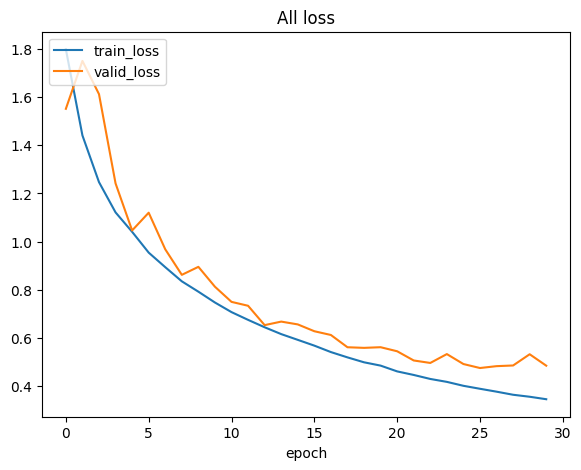

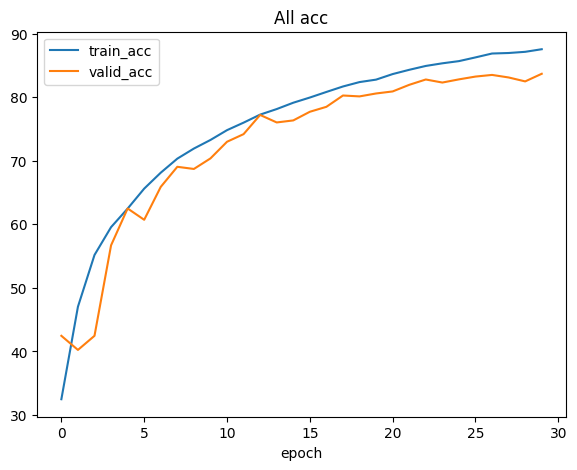

In [10]:
##### Plot loss & accuracy graph #####
import matplotlib.pyplot as plt
# 學生實作部分：Plot training and validation loss and accuracy curves
def plt_acc_all():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('All acc')

    ax1.plot(train_accuracies)
    ax1.plot(val_accuracies)

    ax1.legend(['train_acc', 'valid_acc'], loc='upper left')
    ax1.set_xlabel('epoch')
    plt.show()

def plt_loss_all():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('All loss')

    ax1.plot(train_losses)
    ax1.plot(val_losses)

    ax1.legend(['train_loss', 'valid_loss'], loc='upper left')
    ax1.set_xlabel('epoch')
    plt.show()


plt_loss_all()
plt_acc_all()